# CatBoost Regression Model for Electricity Demand Forecasting

This notebook implements a CatBoost regression model to forecast electricity demand in NSW, Australia. The model uses historical demand data, weather information, and temporal features to predict future electricity consumption.

## How to Use This Notebook:

1. **Prerequisites**: Ensure the processed dataset `complete_data.csv` is available in `../../data/processed/`
2. **Run All Cells**: Execute cells sequentially from top to bottom using "Run All" or run each cell individually
3. **Dependencies**: All required packages will be automatically installed in the first code cell
4. **Outputs**: The notebook generates performance metrics, feature importance analysis, and visualisation plots
5. **Results**: Final model performance and predictions are saved in variables accessible throughout the session

## 1. Environment Setup

In [1]:
%pip install pandas --quiet
%pip install catboost scikit-learn matplotlib --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from catboost import CatBoostRegressor
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Data Loading and Preprocessing

### Load Complete Dataset

Loading the preprocessed dataset that contains all features.

In [3]:
# Read in the complete data
complete_data_df = pd.read_csv('../../data/processed/complete_data.csv')

### Feature Engineering: Lag Variables

Creating lag features from previous day and week demand values.

In [4]:
# Sort by datetime to ensure proper order for lag calculations
complete_data_df = complete_data_df.sort_values('datetime_au').reset_index(drop=True)

# Create previous day features for all 30-minute demand metrics (shift by 1 day)
complete_data_df['prev_day_avg_demand'] = complete_data_df['avg_30_min_demand'].shift(1)
complete_data_df['prev_day_min_demand'] = complete_data_df['min_30_min_demand'].shift(1)
complete_data_df['prev_day_max_demand'] = complete_data_df['max_30_min_demand'].shift(1)
complete_data_df['prev_day_sum_demand'] = complete_data_df['sum_30_min_demand'].shift(1)

# Drop rows with missing lag features (first row will have NaN values)
complete_data_df = complete_data_df.dropna(subset=['prev_day_avg_demand', 'prev_day_min_demand', 'prev_day_max_demand', 'prev_day_sum_demand']).reset_index(drop=True)

# Create previous week features for all 30-minute demand metrics (shift by 7 days)
complete_data_df['prev_week_avg_demand'] = complete_data_df['avg_30_min_demand'].shift(7)
complete_data_df['prev_week_min_demand'] = complete_data_df['min_30_min_demand'].shift(7)
complete_data_df['prev_week_max_demand'] = complete_data_df['max_30_min_demand'].shift(7)
complete_data_df['prev_week_sum_demand'] = complete_data_df['sum_30_min_demand'].shift(7)

# Drop rows with missing weekly lag features (first 7 rows will have NaN values)
complete_data_df = complete_data_df.dropna(subset=['prev_week_avg_demand', 'prev_week_min_demand', 'prev_week_max_demand', 'prev_week_sum_demand']).reset_index(drop=True)

### Train-Test Split and Feature Selection

Splitting data chronologically: 2016-2018 for training, 2019 for testing. Features include weather data, temporal patterns, seasonal indicators, and lag variables.

In [5]:
# Re-create train/test split with all features
complete_data_df['datetime_au'] = pd.to_datetime(complete_data_df['datetime_au'])
complete_data_df['year'] = complete_data_df['datetime_au'].dt.year

# Split data into training (2016-2018) and testing (2019) with all features
train_data_full = complete_data_df[complete_data_df['year'].isin([2016, 2017, 2018])].copy()
test_data_full = complete_data_df[complete_data_df['year'] == 2019].copy()

# Using all available features including lag features
feature_columns = [
    'is_weekend', 'is_weekday', 'avg_temp', 'min_temp', 'max_temp',
    'is_summer', 'is_autumn', 'is_winter', 'is_spring',
    'is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday', 'is_saturday', 'is_sunday',
    'precipitation', 'sunlight', 'hd_next_24h', 'cd_next_24h',
    'is_jan', 'is_feb', 'is_mar', 'is_apr', 'is_may', 'is_jun',
    'is_jul', 'is_aug', 'is_sep', 'is_oct', 'is_nov', 'is_dec',
    'prev_day_avg_demand', 'prev_day_min_demand', 'prev_day_max_demand', 'prev_day_sum_demand',
    'prev_week_avg_demand', 'prev_week_min_demand', 'prev_week_max_demand', 'prev_week_sum_demand'
]

# Target variable - total daily demand
target_column = 'sum_30_min_demand'

# Prepare training data (2016-2018)
X_train = train_data_full[feature_columns].copy()
y_train = train_data_full[target_column].copy()

# Prepare test data (2019)
X_test = test_data_full[feature_columns].copy()
y_test = test_data_full[target_column].copy()

### Evaluation Function

Function to calculate standard regression metrics: RMSE, MAE, R², and MAPE.

In [6]:
# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    """Calculate and display model evaluation metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = float(np.mean(np.abs((y_true - y_pred) / y_true)) * 100)
    return {'RMSE': rmse, 'MAE': mae, 'R²': r2, 'MAPE': mape}

## 2. Hyperparameter Tuning

### Hyperparameter Tuning Results Analysis

Analysing the performance of different parameter combinations and displaying the best performing models based on test MAPE (Mean Absolute Percentage Error).

In [ ]:
# Defining parameter grid for tuning (uncomment this section to perform hyperparameter tuning)
# param_grid = {
#     'iterations': [100, 250, 500, 750, 1000],         # Number of boosting iterations
#     'depth': [2, 4, 6, 8, 10],                        # Tree depth
#     'learning_rate': [0.02, 0.05, 0.1, 0.15, 0.2],    # Learning rate for gradient boosting
#     'subsample': [0.6, 0.7, 0.8, 0.9],                # Fraction of samples used for each tree
#     'colsample_bylevel': [0.6, 0.7, 0.8, 0.9],        # Fraction of features used at each level
#     'l2_leaf_reg': [1, 3, 5]                          # L2 regularisation parameter
# }

# Using optimised hyperparameters (best values from previous tuning)
param_grid = {
    'iterations': [500],         # Number of boosting iterations
    'depth': [6],                # Tree depth
    'learning_rate': [0.15],     # Learning rate for gradient boosting
    'subsample': [0.7],          # Fraction of samples used for each tree
    'colsample_bylevel': [0.6],  # Fraction of features used at each level
    'l2_leaf_reg': [1]           # L2 regularisation parameter
}

# Initialising variables for best model selection
best_model = None
best_params = None
best_test_mape = float('inf')
results = []

# Grid search: test all parameter combinations
for iterations in param_grid['iterations']:
    for depth in param_grid['depth']:
        for learning_rate in param_grid['learning_rate']:
            for subsample in param_grid['subsample']:
                for colsample_bylevel in param_grid['colsample_bylevel']:
                    for l2_leaf_reg in param_grid['l2_leaf_reg']:
                        
                        # Create CatBoost model with current parameters
                        model = CatBoostRegressor(
                            iterations=iterations,
                            depth=depth,
                            learning_rate=learning_rate,
                            subsample=subsample,
                            colsample_bylevel=colsample_bylevel,
                            l2_leaf_reg=l2_leaf_reg,
                            loss_function='RMSE',    # Regression loss function
                            random_seed=1,           # For reproducibility
                            verbose=False,           # Suppress training output
                            thread_count=-1          # Use all available CPU cores
                        )
                        
                        # Train the model
                        model.fit(X_train, y_train)
                        
                        # Generate predictions for both train and test sets
                        y_train_pred = model.predict(X_train)
                        y_test_pred = model.predict(X_test)
                        
                        # Calculate comprehensive metrics
                        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
                        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
                        train_mae = mean_absolute_error(y_train, y_train_pred)
                        test_mae = mean_absolute_error(y_test, y_test_pred)
                        train_r2 = r2_score(y_train, y_train_pred)
                        test_r2 = r2_score(y_test, y_test_pred)
                        train_mape = float(np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100)
                        test_mape = float(np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100)
                        
                        # Store all results for later analysis
                        result = {
                            'iterations': iterations,
                            'depth': depth,
                            'learning_rate': learning_rate,
                            'subsample': subsample,
                            'colsample_bylevel': colsample_bylevel,
                            'l2_leaf_reg': l2_leaf_reg,
                            'train_rmse': train_rmse,
                            'test_rmse': test_rmse,
                            'train_mae': train_mae,
                            'test_mae': test_mae,
                            'train_r2': train_r2,
                            'test_r2': test_r2,
                            'train_mape': train_mape,
                            'test_mape': test_mape
                        }
                        results.append(result)
                        
                        # Update best model if current model performs better (lower MAPE is better)
                        if test_mape < best_test_mape:
                            best_test_mape = test_mape
                            best_model = model
                            best_params = {
                                'iterations': iterations,
                                'depth': depth,
                                'learning_rate': learning_rate,
                                'subsample': subsample,
                                'colsample_bylevel': colsample_bylevel,
                                'l2_leaf_reg': l2_leaf_reg
                            }

# Print best parameters and corresponding test MAPE according to best model found
print(f"\nBest parameters: {best_params}")
print(f"Best test MAPE: {best_test_mape:.2f}%")

# Generate final predictions using the best model
y_train_pred_orig = best_model.predict(X_train)
y_test_pred_orig = best_model.predict(X_test)


Best parameters: {'iterations': 500, 'depth': 6, 'learning_rate': 0.15, 'subsample': 0.7, 'colsample_bylevel': 0.6, 'l2_leaf_reg': 1}
Best test MAPE: 1.93%


### Comprehensive Statics for all Parameter Combinations

In [8]:
# Convert results to dataframe for easier data manipulation
results_df = pd.DataFrame(results)

# Sort by test MAPE (lower is better)
results_df_sorted = results_df.sort_values('test_mape').reset_index(drop=True)

# Print top 10 best parameter combinations
print("Top 10 Best Parameter Combinations (by Test MAPE):")
print("="*80)
for i in range(min(10, len(results_df_sorted))):
    row = results_df_sorted.iloc[i]
    print(f"Rank {i+1}:")
    print(f"  Parameters: iterations={row['iterations']}, depth={row['depth']}, "
          f"learning_rate={row['learning_rate']}, subsample={row['subsample']}, "
          f"colsample_bylevel={row['colsample_bylevel']}, l2_leaf_reg={row['l2_leaf_reg']}")
    print(f"  Test Metrics:  MAPE={row['test_mape']:.2f}%, RMSE={row['test_rmse']:.2f}, "
          f"MAE={row['test_mae']:.2f}, R²={row['test_r2']:.4f}")
    print(f"  Train Metrics: MAPE={row['train_mape']:.2f}%, RMSE={row['train_rmse']:.2f}, "
          f"MAE={row['train_mae']:.2f}, R²={row['train_r2']:.4f}")
    print()

# Display comprehensive statistics for all metrics
print("\nDetailed Parameter Search Statistics:")
print("="*40)

print("\nMAPE Statistics:")
print("-" * 16)
print(f"Best Test MAPE:   {results_df_sorted['test_mape'].min():.2f}%")
print(f"Worst Test MAPE:  {results_df_sorted['test_mape'].max():.2f}%")
print(f"Mean Test MAPE:   {results_df_sorted['test_mape'].mean():.2f}%")
print(f"Median Test MAPE: {results_df_sorted['test_mape'].median():.2f}%")
print(f"Std Test MAPE:    {results_df_sorted['test_mape'].std():.2f}%")
print(f"MAPE Range:       {results_df_sorted['test_mape'].max() - results_df_sorted['test_mape'].min():.2f}% points")

print("\nRMSE Statistics:")
print("-" * 16)
print(f"Best Test RMSE:   {results_df_sorted['test_rmse'].min():.2f}")
print(f"Worst Test RMSE:  {results_df_sorted['test_rmse'].max():.2f}")
print(f"Mean Test RMSE:   {results_df_sorted['test_rmse'].mean():.2f}")
print(f"Median Test RMSE: {results_df_sorted['test_rmse'].median():.2f}")
print(f"Std Test RMSE:    {results_df_sorted['test_rmse'].std():.2f}")

print("\nMAE Statistics:")
print("-" * 15)
print(f"Best Test MAE:    {results_df_sorted['test_mae'].min():.2f}")
print(f"Worst Test MAE:   {results_df_sorted['test_mae'].max():.2f}")
print(f"Mean Test MAE:    {results_df_sorted['test_mae'].mean():.2f}")
print(f"Median Test MAE:  {results_df_sorted['test_mae'].median():.2f}")
print(f"Std Test MAE:     {results_df_sorted['test_mae'].std():.2f}")

print("\nR² Statistics:")
print("-" * 14)
print(f"Best Test R²:     {results_df_sorted['test_r2'].max():.4f}")
print(f"Worst Test R²:    {results_df_sorted['test_r2'].min():.4f}")
print(f"Mean Test R²:     {results_df_sorted['test_r2'].mean():.4f}")
print(f"Median Test R²:   {results_df_sorted['test_r2'].median():.4f}")
print(f"Std Test R²:      {results_df_sorted['test_r2'].std():.4f}")

Top 10 Best Parameter Combinations (by Test MAPE):
Rank 1:
  Parameters: iterations=500.0, depth=6.0, learning_rate=0.15, subsample=0.7, colsample_bylevel=0.6, l2_leaf_reg=1.0
  Test Metrics:  MAPE=1.93%, RMSE=10525.20, MAE=7304.61, R²=0.9210
  Train Metrics: MAPE=0.20%, RMSE=964.81, MAE=752.14, R²=0.9993


Detailed Parameter Search Statistics:

MAPE Statistics:
----------------
Best Test MAPE:   1.93%
Worst Test MAPE:  1.93%
Mean Test MAPE:   1.93%
Median Test MAPE: 1.93%
Std Test MAPE:    nan%
MAPE Range:       0.00% points

RMSE Statistics:
----------------
Best Test RMSE:   10525.20
Worst Test RMSE:  10525.20
Mean Test RMSE:   10525.20
Median Test RMSE: 10525.20
Std Test RMSE:    nan

MAE Statistics:
---------------
Best Test MAE:    7304.61
Worst Test MAE:   7304.61
Mean Test MAE:    7304.61
Median Test MAE:  7304.61
Std Test MAE:     nan

R² Statistics:
--------------
Best Test R²:     0.9210
Worst Test R²:    0.9210
Mean Test R²:     0.9210
Median Test R²:   0.9210
Std Test R²: 

## 3. Feature Importance Analysis

Understanding which features contribute most to the model's predictions.

In [9]:
# Extract feature importance from the best model
feature_importance = best_model.get_feature_importance()
feature_names = feature_columns

# Create a dataframe for easier data manipulation
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Feature Importance Rankings:")
print("="*50)
for i, (_, row) in enumerate(importance_df.iterrows(), 1):
    print(f"{i:2d}. {row['feature']:25s} {row['importance']:.4f}")

Feature Importance Rankings:
 1. prev_day_avg_demand       13.5349
 2. prev_day_sum_demand       11.6640
 3. is_weekday                11.1360
 4. cd_next_24h               10.9470
 5. avg_temp                  10.7875
 6. max_temp                  7.2436
 7. prev_day_max_demand       4.3677
 8. sunlight                  4.2726
 9. is_monday                 3.3702
10. prev_week_avg_demand      2.4540
11. prev_week_sum_demand      2.3909
12. is_weekend                2.0487
13. prev_week_max_demand      1.7865
14. is_saturday               1.7070
15. prev_week_min_demand      1.6563
16. min_temp                  1.4965
17. precipitation             1.4459
18. prev_day_min_demand       1.3851
19. hd_next_24h               1.0388
20. is_sunday                 0.6326
21. is_dec                    0.5624
22. is_spring                 0.5120
23. is_summer                 0.5073
24. is_friday                 0.4980
25. is_winter                 0.4229
26. is_jan                    0.4132
27. 

### Feature Importance Visualisation

Visualising which features contribute most to the model's predictions.

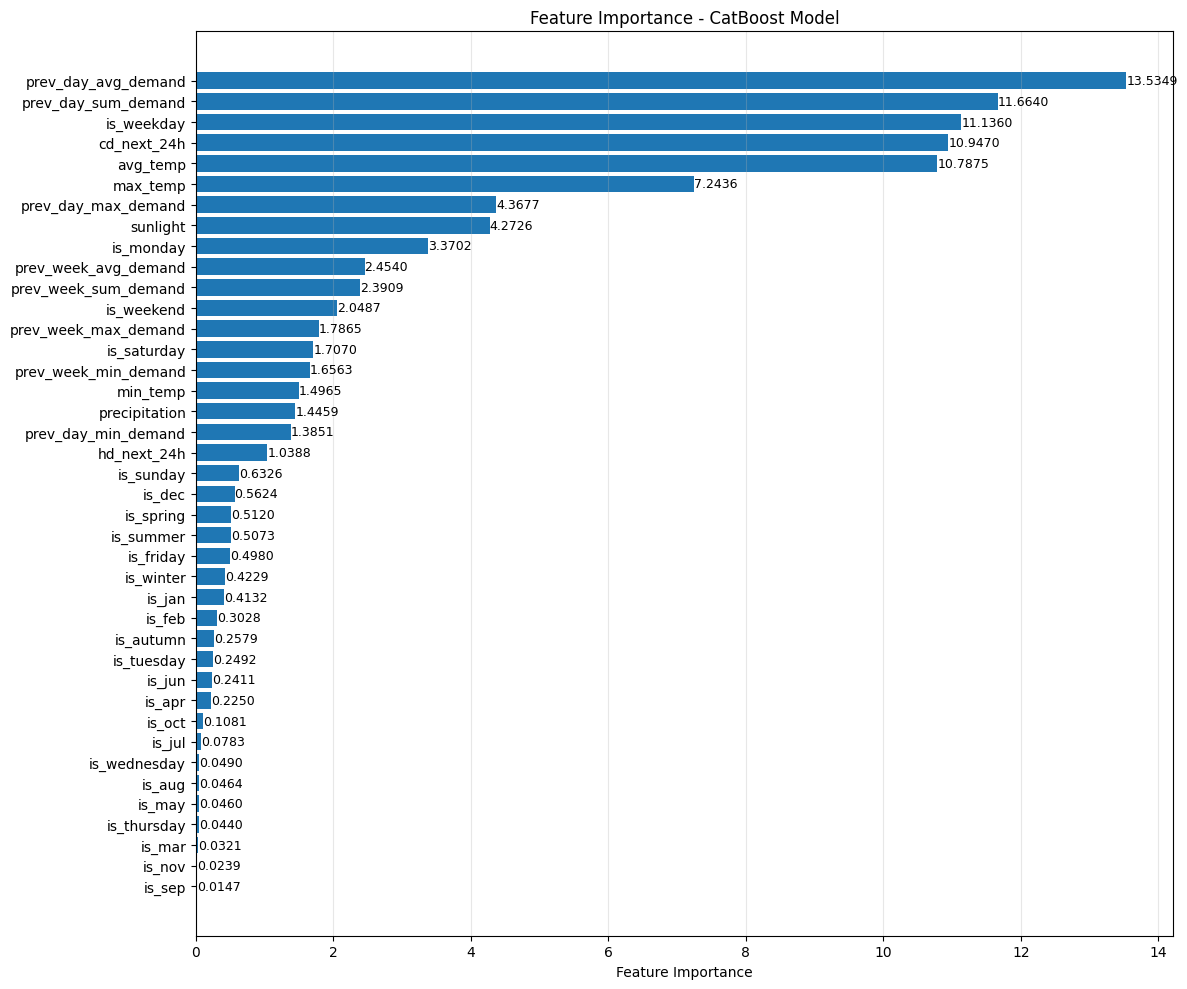

In [10]:
# Feature importance visualization
plt.figure(figsize=(12, 10))

# Plot all features
top_40_features = importance_df.head(40)
bars = plt.barh(range(len(top_40_features)), top_40_features['importance'])
plt.yticks(range(len(top_40_features)), top_40_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance - CatBoost Model')
plt.gca().invert_yaxis()

# Add value labels on bars
for i, (_, row) in enumerate(top_40_features.iterrows()):
    plt.text(row['importance'] + 0.001, i, f'{row["importance"]:.4f}', 
             va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.grid(axis='x', alpha=0.3)
plt.show()

### Feature Category Analysis

Grouping features by categories (weather, seasonality, lag features, etc.) to understand which types of information are most valuable for prediction.

Feature Importance by Category:

DAY_LAG_FEATURES (4 features)
----------------------------------------
Total Importance: 30.9517
Average Importance per Feature: 7.7379
Individual Features:
  • prev_day_avg_demand       13.5349 (13.5%)
  • prev_day_sum_demand       11.6640 (11.7%)
  • prev_day_max_demand       4.3677 (4.4%)
  • prev_day_min_demand       1.3851 (1.4%)

WEATHER (5 features)
----------------------------------------
Total Importance: 25.2460
Average Importance per Feature: 5.0492
Individual Features:
  • avg_temp                  10.7875 (10.8%)
  • max_temp                  7.2436 (7.2%)
  • sunlight                  4.2726 (4.3%)
  • min_temp                  1.4965 (1.5%)
  • precipitation             1.4459 (1.4%)

DAY_OF_WEEK (9 features)
----------------------------------------
Total Importance: 19.7346
Average Importance per Feature: 2.1927
Individual Features:
  • is_weekday                11.1360 (11.1%)
  • is_monday                 3.3702 (3.4%)
  • is_weekend  

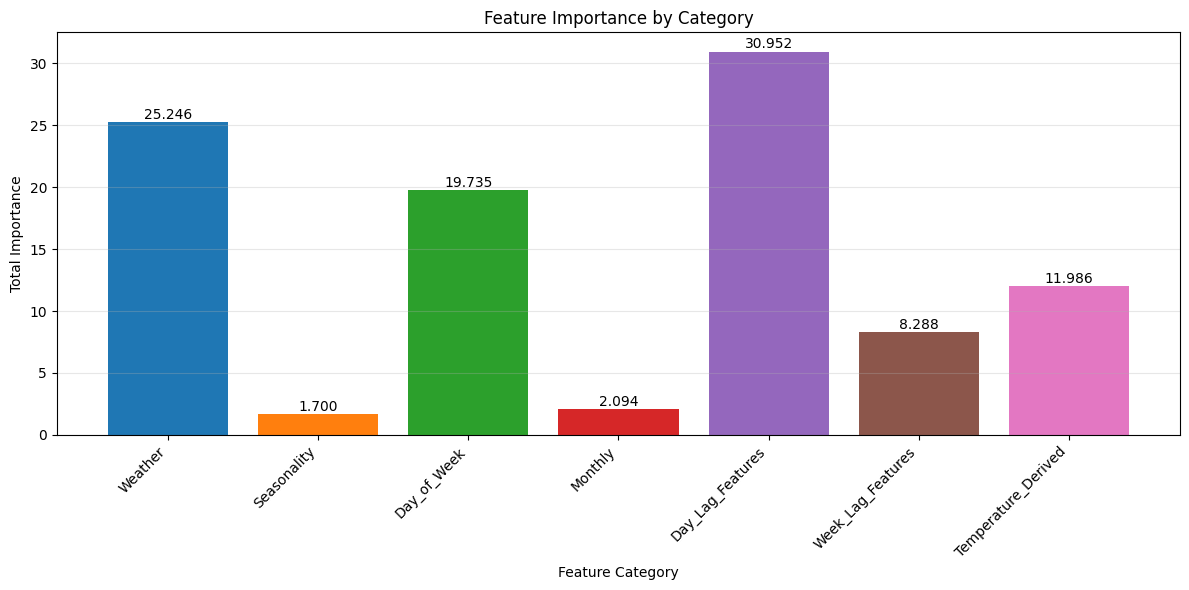

In [11]:
# Feature importance analysis by category
def analyse_feature_categories(importance_df):
    """Analyse feature importance by different categories"""
    
    # Define feature categories for better analysis
    categories = {
        'Weather': ['avg_temp', 'min_temp', 'max_temp', 'precipitation', 'sunlight'],
        'Seasonality': ['is_summer', 'is_autumn', 'is_winter', 'is_spring'],
        'Day_of_Week': ['is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 
                       'is_friday', 'is_saturday', 'is_sunday', 'is_weekend', 'is_weekday'],
        'Monthly': ['is_jan', 'is_feb', 'is_mar', 'is_apr', 'is_may', 'is_jun',
                   'is_jul', 'is_aug', 'is_sep', 'is_oct', 'is_nov', 'is_dec'],
        'Day_Lag_Features': ['prev_day_avg_demand', 'prev_day_min_demand', # Day lag features
                        'prev_day_max_demand', 'prev_day_sum_demand'],
        'Week_Lag_Features': ['prev_week_avg_demand', 'prev_week_min_demand', # Week lag features
                        'prev_week_max_demand', 'prev_week_sum_demand'],
        'Temperature_Derived': ['hd_next_24h', 'cd_next_24h']  # Heating/cooling degree days
    }
    
    # Calculate importance metrics for each category
    category_importance = {}
    for category, features in categories.items():
        category_features = importance_df[importance_df['feature'].isin(features)]
        total_importance = category_features['importance'].sum()
        category_importance[category] = {
            'total_importance': total_importance,
            'feature_count': len(category_features),
            'avg_importance': total_importance / len(category_features) if len(category_features) > 0 else 0,
            'features': category_features.sort_values('importance', ascending=False)
        }
    
    return category_importance

# Perform category analysis
category_analysis = analyse_feature_categories(importance_df)

print("Feature Importance by Category:")
print("="*60)
# Sort categories by total importance (most important first)
for category, data in sorted(category_analysis.items(), key=lambda x: x[1]['total_importance'], reverse=True):
    print(f"\n{category.upper()} ({data['feature_count']} features)")
    print("-" * 40)
    print(f"Total Importance: {data['total_importance']:.4f}")
    print(f"Average Importance per Feature: {data['avg_importance']:.4f}")
    print("Individual Features:")
    for _, row in data['features'].iterrows():
        # Calculate percentage contribution of each feature
        percentage = (row['importance'] / importance_df['importance'].sum()) * 100
        print(f"  • {row['feature']:25s} {row['importance']:.4f} ({percentage:.1f}%)")

# Creating bar chart for category importance
plt.figure(figsize=(12, 6))
categories = list(category_analysis.keys())
total_importances = [category_analysis[cat]['total_importance'] for cat in categories]
bars = plt.bar(categories, total_importances, color=plt.cm.tab10(range(len(categories))))
plt.xlabel('Feature Category')
plt.ylabel('Total Importance')
plt.title('Feature Importance by Category')
plt.xticks(rotation=45, ha='right')

# Add value labels on bars
for i, (cat, importance) in enumerate(zip(categories, total_importances)):
    plt.text(i, importance + 0.01, f'{importance:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

## 4. Model Performance Results Visualisation

Comprehensive visualisation of model performance including scatter plots, residual analysis, and time series comparison between actual and predicted values.

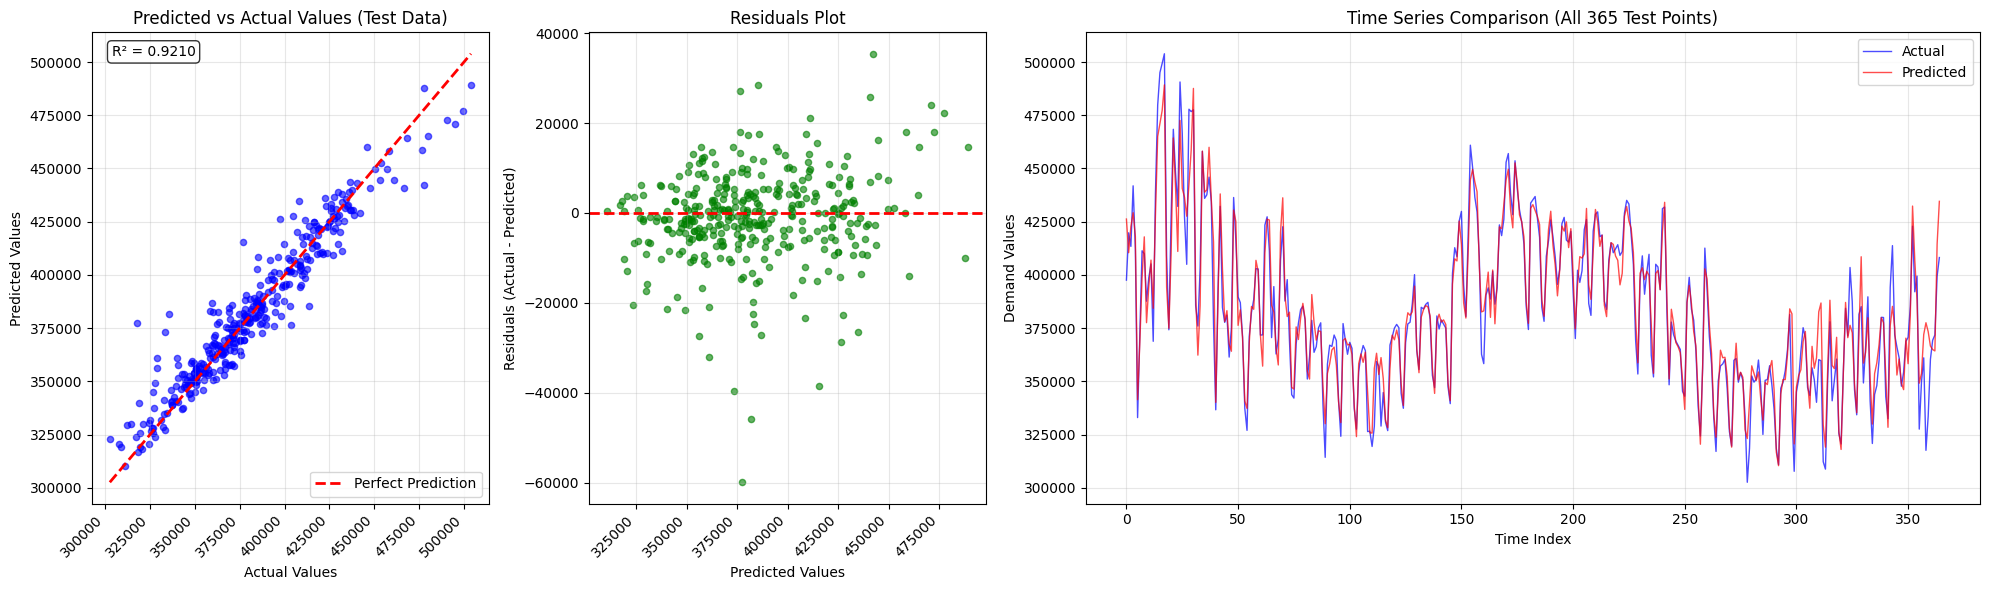

In [12]:
# Creating a subplot
plt.figure(figsize=(20, 6))

# Plot 1: Scatter plot of predicted vs actual demand values
plt.subplot2grid((1, 4), (0, 0))
plt.scatter(y_test, y_test_pred, alpha=0.6, color='blue', s=20)
# Adding perfect prediction line (45-degree line) for reference
min_val = min(min(y_test), min(y_test_pred))
max_val = max(max(y_test), max(y_test_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
# Adding plot labels, title, legend and general formatting
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (Test Data)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}'))
# Add R² score annotation to the plot
r2 = r2_score(y_test, y_test_pred)
plt.text(0.05, 0.95, f'R² = {r2:.4f}', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 2: Residuals plot
plt.subplot2grid((1, 4), (0, 1))
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals, alpha=0.6, color='green', s=20)
plt.axhline(y=0, color='red', linestyle='--', lw=2)  # Zero residual line
# Adding plot labels, title, legend and general formatting
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals Plot')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}'))

# Plot 3: Time series comparison of predicted and actual demand values
plt.subplot2grid((1, 4), (0, 2), colspan=2)
# Plot the entire test dataset chronologically
n_points = len(y_test)
indices = range(n_points)
plt.plot(indices, y_test.iloc[:], 'b-', label='Actual', linewidth=1, alpha=0.7)
plt.plot(indices, y_test_pred[:], 'r-', label='Predicted', linewidth=1, alpha=0.7)
# Adding plot labels, title, legend and general formatting
plt.xlabel('Time Index')
plt.ylabel('Demand Values')
plt.title(f'Time Series Comparison (All {n_points} Test Points)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()